In [40]:
import os
os.getcwd()

'/home/derick/Documents/PINN-elastodynamics/SteelSHM/train'

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from utils import GenDist

%matplotlib inline

In [42]:
rho = 7.9e3 #7900
E = 1.8e11 #180e9
nu = 0.3
mu0 = E/(2*(1+nu))
lambda0 = E*nu/((1+nu)*(1-2*nu))

In [43]:
V0 = 1e-12 #1e-8
f0 = 120e3
n0 = 5
t_tot = 4.167e-5
tmax = 2.083e-4  

In [44]:
nondim= True

In [45]:
# nondim= False

In [46]:
if nondim:
    L_star = 0.3 
    T_star = L_star*np.sqrt(rho/mu0) 
    U_star = V0
    S_star = rho*L_star*U_star/(T_star**2)
else:
    L_star = 1 
    T_star = 1 
    U_star = 1 
    S_star = 1 

In [47]:
# Create a grid of x and z values
w = 0.3/L_star
h = 0.004/L_star
tmax = 2.083e-4/T_star

x = np.linspace(0, w, 100)
z = np.linspace(0, h, 100)
x, z = np.meshgrid(x, z)

x = x.flatten()[:, None]
z = z.flatten()[:, None]

tval = tmax * 0.5 * np.ones_like(x)

In [48]:
XYT_dist = np.concatenate((x, z, tval), 1)

In [49]:
_, values = GenDist(XYT_dist, w, h)
Du_values, Dv_values, Dxx_values, Dzz_values, Dxz_values = values
Du_values  = Du_values.reshape(100, 100)
Dv_values  = Dv_values.reshape(100, 100)
Dxx_values = Dxx_values.reshape(100, 100)
Dzz_values = Dzz_values.reshape(100, 100)
Dxz_values = Dxz_values.reshape(100, 100)

In [50]:
cmap = 'rainbow'#'jet'#'viridis'#'turbo'

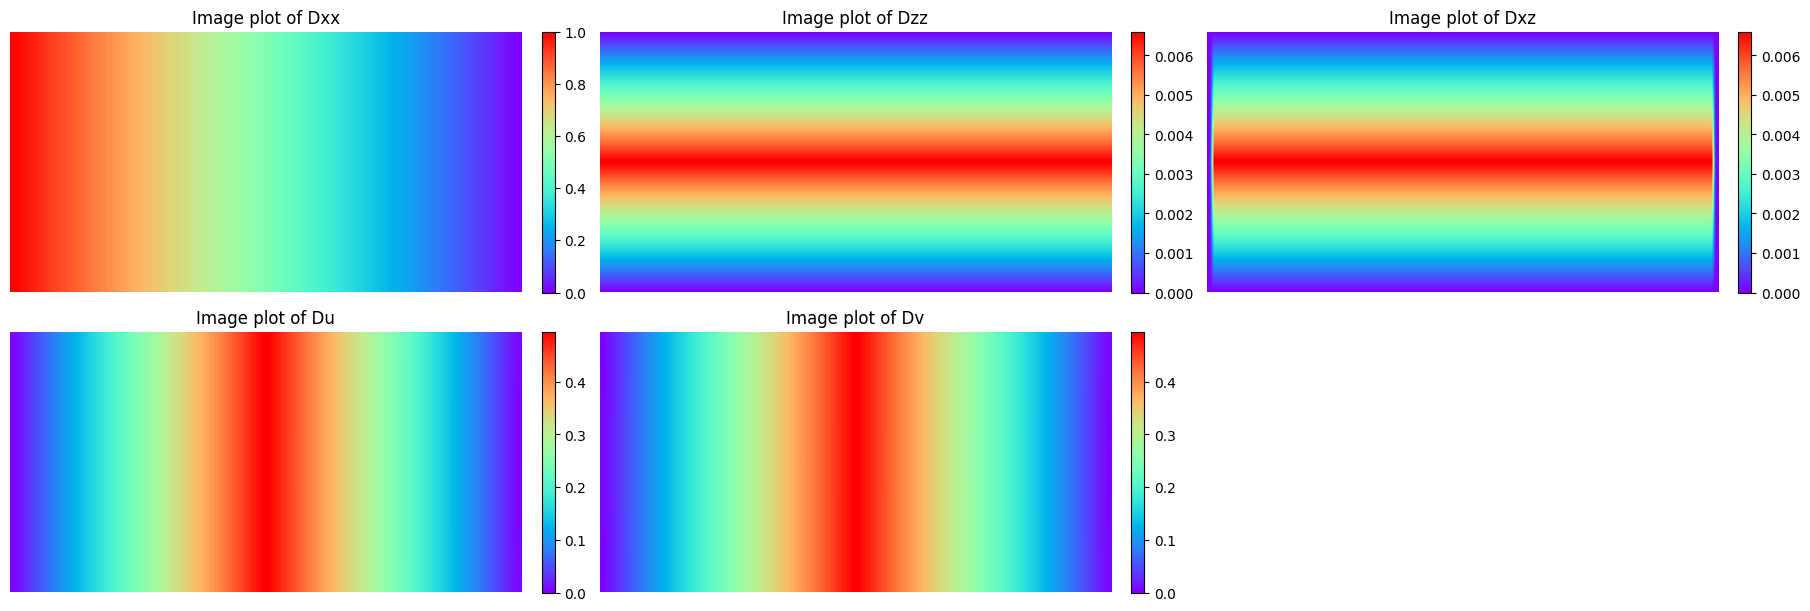

In [51]:
D_vals = {
    'Dxx': Dxx_values,
    'Dzz': Dzz_values,
    'Dxz': Dxz_values,
    'Du': Du_values,
    'Dv': Dv_values,
    'Dxv': Dv_values,
}

fig, axs = plt.subplots(2, 3, figsize=(18, 6), constrained_layout=True)

i = 0
for ax, (key, D_values) in zip(axs.flat, D_vals.items()):
    ax.set_axis_off()
    if i == 5:
        continue
    im = ax.imshow(D_values, extent=[0, w, 0, h], origin='lower', cmap=cmap, aspect='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title(f'Image plot of {key}')
    # ax.set_axis_off()
    # print(i)
    
    # Create a colorbar with the same height as the imshow
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    i += 1

plt.show()

In [52]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
from models import PINN
from utils import GenDist, GenDistPt
from utils_shm import f_exc
from pyDOE import lhs

In [54]:
x = np.linspace(0, w, 100)
z = np.linspace(0, h, 100)
x, z = np.meshgrid(x, z)

x = x.flatten()[:, None]
z = z.flatten()[:, None]

tval = tmax * 0.5 * np.ones_like(x)

In [55]:
nondim = True

w = 0.3
h = 0.004
in_size = 9529
in_size = 9529
lr_size = 512 #1024#128
tb_size = 512 #int(lr_size/2)

rho = 7.9e3 #7900
E = 1.8e11 #180e9
nu = 0.3
mu0 = E/(2*(1+nu))
lambda0 = E*nu/((1+nu)*(1-2*nu))

V0 = 1e-12 #1e-8
f0 = 120e3
n0 = 5
t_tot = 4.167e-5
tmax = 2.083e-4  

T = tmax  

# Domain bounds for x, y and t
lb = np.array([0, 0, 0.0])
ub = np.array([w, h, tmax])

# Network configuration
uv_layers   = [3] + 8 * [70] + [5]
dist_layers = [3] + 4 * [20] + [5]
part_layers = [3] + 4 * [20] + [5]

# Number of frames for postprocessing

# Initial condition point for u, v
IC = lb + np.array([w, h, 0.0]) * lhs(3, 5000)

# Collocation point for equation residual
XYT_c = lb + (ub - lb) * lhs(3, 10000)

# P1 = np.array([0, 0, 0.0])
# P2 = np.array([0, h, 0.0])
# P3 = np.array([w, h/2, 0.0])
dense = 10
XYT_P1 = np.array([0        , 0          , 0]) + np.array([w/dense, h/dense  , T]) * lhs(3, 4000) 
XYT_P2 = np.array([0        , h  -h/dense, 0]) + np.array([w/dense, h/dense  , T]) * lhs(3, 4000) 
XYT_P3 = np.array([w-w/dense, h/2-h/dense, 0]) + np.array([w/dense, 2*h/dense, T]) * lhs(3, 8000) 

XYT_c = np.concatenate((XYT_c, XYT_P1, XYT_P2, XYT_P3), 0)

LW = np.array([0, 0, 0]) + np.array([w, 0, T]) * lhs(3, 8000)
UP = np.array([0, h, 0]) + np.array([w, 0, T]) * lhs(3, 8000)
LF = np.array([0, 0, 0]) + np.array([0, h, T]) * lhs(3, 8000)
RT = np.array([w, 0, 0]) + np.array([0, h, T]) * lhs(3, 8000)

P1 = np.array([0, 0  , 0]) + np.array([0, 0, T]) * lhs(3, 4000)
P2 = np.array([0, h  , 0]) + np.array([0, 0, T]) * lhs(3, 4000)
P3 = np.array([w, h/2, 0]) + np.array([0, 0, T]) * lhs(3, 4000)

t_P1 = P1[:, 2:3]
t_P2 = P2[:, 2:3]

v_P1 = f_exc(P1[:,1:2], P1[:,2:3])
v_P2 = f_exc(P2[:,1:2], P2[:,2:3])

P1 = np.concatenate((P1, v_P1), 1)
P2 = np.concatenate((P2, v_P2), 1)

# Add some boundary points into the collocation point set
XYT_c = np.concatenate((XYT_c, LF[::5, :], RT[::5, :], UP[::5, :], LW[::5, :], P1[::5, 0:3], P2[::5, 0:3], P3[::5, :]), 0)

x_dist, y_dist, t_dist = GenDistPt(xmin=0, xmax=w, ymin=0, ymax=h, tmin=0, tmax=T,
                                    num=21, num_t=21)
XYT_dist = np.concatenate((x_dist, y_dist, t_dist), 1)
DIST, _ = GenDist(XYT_dist, w, h)

if nondim == True:
    # Nondimensionalization parameters
    L_star = 0.3 
    T_star = L_star*np.sqrt(rho/mu0) 
    U_star = V0
    S_star = rho*L_star*U_star/(T_star**2)

    var_star = np.array([L_star, L_star, T_star])
    var_star_U = np.array([L_star, L_star, T_star, U_star])
    # Nondimensionalize coordinates and inflow velocity
    XYT_c /= var_star 
    P1 /= var_star_U
    P2 /= var_star_U
    P3 /= var_star 
    IC /= var_star 
    LF /= var_star 
    RT /= var_star 
    UP /= var_star 
    LW /= var_star 
    lb /= var_star 
    ub /= var_star 

    w /= L_star
    h /= L_star
    T /= T_star
    tmax /= T_star

    # Replot non-dimensionalised points

    # Generate distance function for spatio-temporal space
    x_dist, y_dist, t_dist = GenDistPt(xmin=0, xmax=w, ymin=0, ymax=h, tmin=0, tmax=T,
                                    num=21, num_t=21)
    XYT_dist = np.concatenate((x_dist, y_dist, t_dist), 1)
    DIST, _ = GenDist(XYT_dist, w, h)
    
else:
    L_star = 1.0
    T_star = 1.0
    U_star = 1.0
    S_star = 1.0

In [56]:
os. getcwd() 

'/home/derick/Documents/PINN-elastodynamics/SteelSHM/train'

In [57]:
time_var = '20240809-005919'
direct = '/home/derick/Documents/PINN-elastodynamics/SteelSHM/PINN_result/'+time_var

# Provide directory (second init) for pretrained networks if you have
model = PINN(XYT_c, P1, P2, P3, IC, LF, RT, UP, LW, DIST, 
                uv_layers, dist_layers, part_layers, 
                lb, ub, 
                rho, mu0, lambda0, 
                L_star, T_star, U_star, S_star, 
                direct,
                partDir='/partNN_float64.pickle', 
                distDir='/distNN_float64.pickle', 
                uvDir='')

Loading dist NN ...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Loading part NN ...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
Varia

In [58]:
values = model.predict_D(x, z, tval)

Du_values, Dv_values, Dxx_values, Dzz_values, Dxz_values = values
Du_values  = Du_values.reshape(100, 100)
Dv_values  = Dv_values.reshape(100, 100)
Dxx_values = Dxx_values.reshape(100, 100)
Dzz_values = Dzz_values.reshape(100, 100)
Dxz_values = Dxz_values.reshape(100, 100)

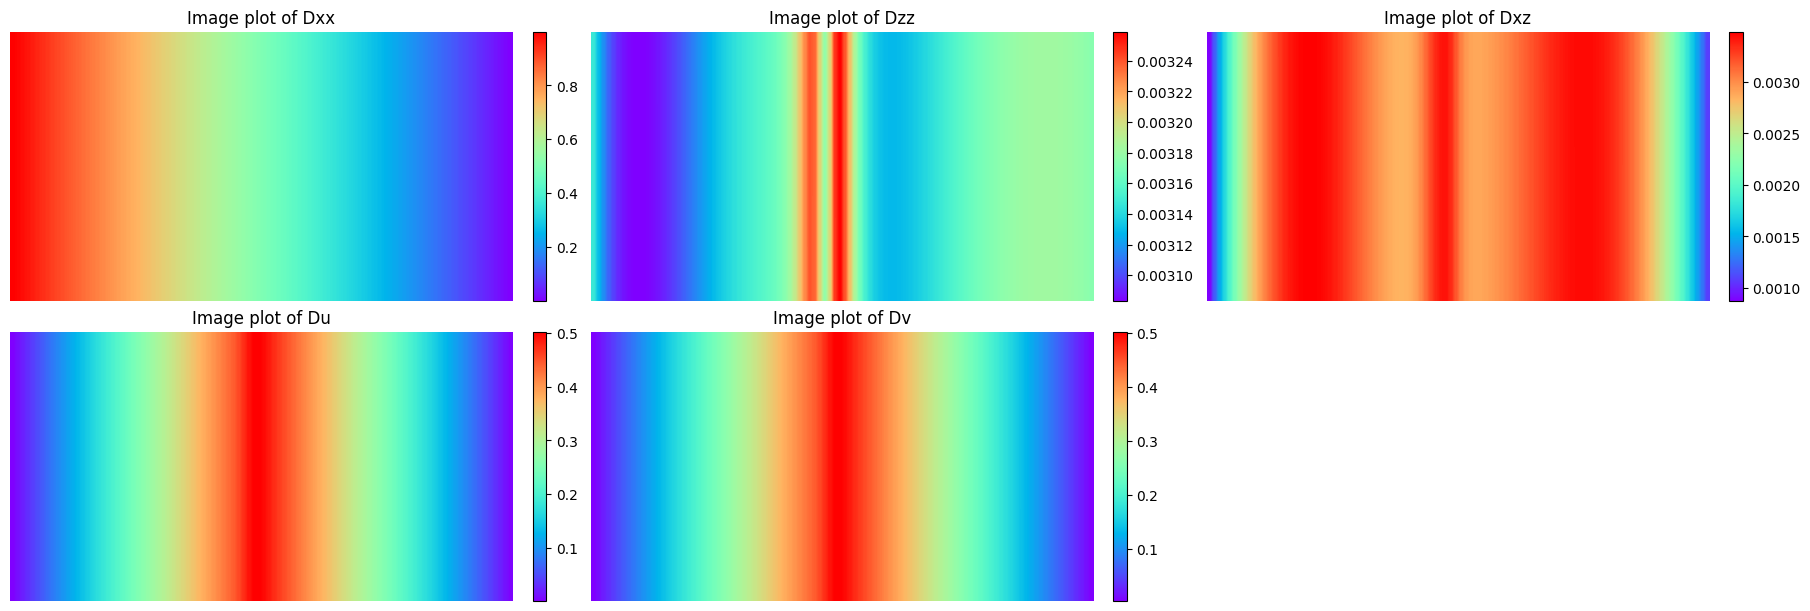

In [59]:
D_vals = {
    'Dxx': Dxx_values,
    'Dzz': Dzz_values,
    'Dxz': Dxz_values,
    'Du': Du_values,
    'Dv': Dv_values,
    'Dxv': Dv_values,
}

fig, axs = plt.subplots(2, 3, figsize=(18, 6), constrained_layout=True)

i = 0
for ax, (key, D_values) in zip(axs.flat, D_vals.items()):
    ax.set_axis_off()
    if i == 5:
        continue
    im = ax.imshow(D_values, extent=[0, w, 0, h], origin='lower', cmap=cmap, aspect='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title(f'Image plot of {key}')
    # ax.set_axis_off()
    # print(i)
    
    # Create a colorbar with the same height as the imshow
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    i += 1

plt.show()

In [60]:
values = model.predict_P(x, z, tval)

Du_values, Dv_values, Dxx_values, Dzz_values, Dxz_values = values
Du_values  = Du_values.reshape(100, 100)
Dv_values  = Dv_values.reshape(100, 100)
Dxx_values = Dxx_values.reshape(100, 100)
Dzz_values = Dzz_values.reshape(100, 100)
Dxz_values = Dxz_values.reshape(100, 100)

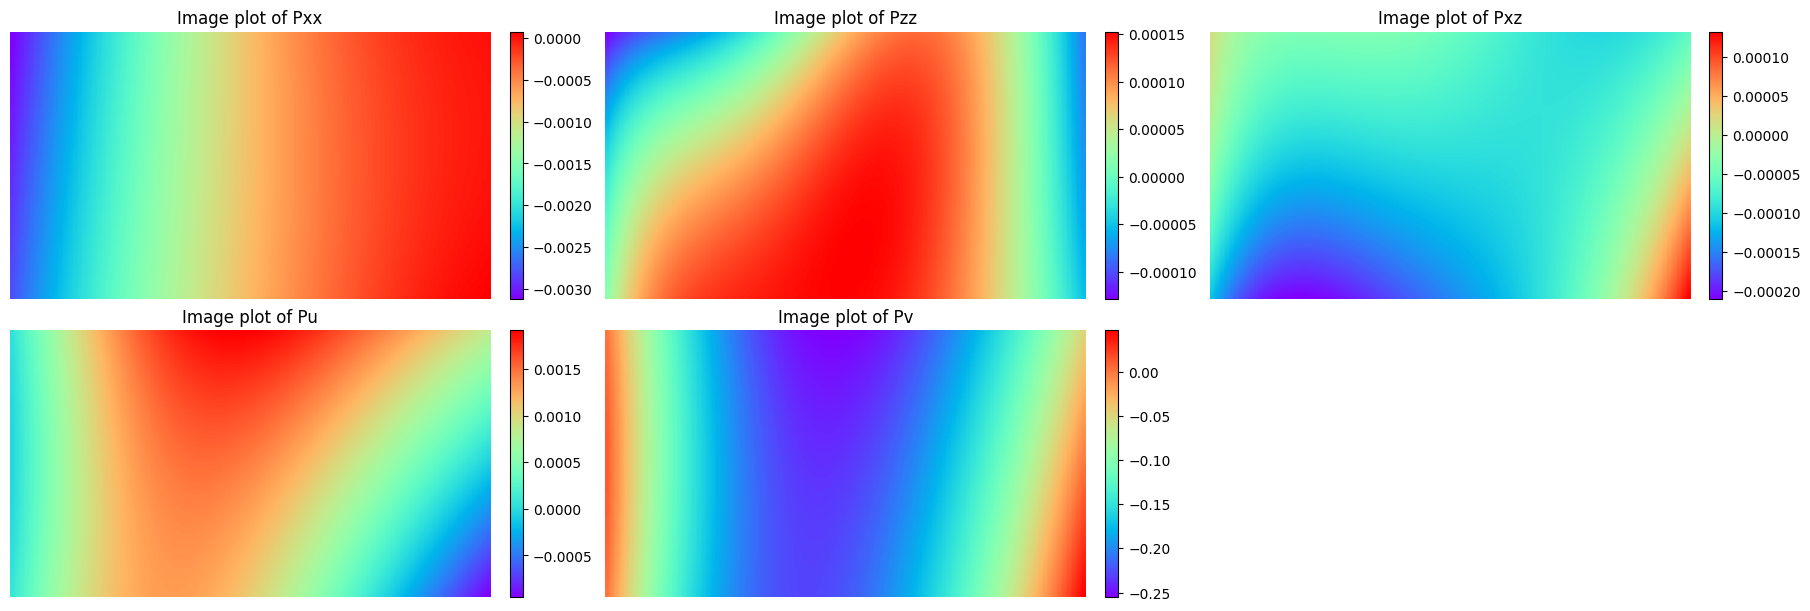

In [61]:
D_vals = {
    'Pxx': Dxx_values,
    'Pzz': Dzz_values,
    'Pxz': Dxz_values,
    'Pu': Du_values,
    'Pv': Dv_values,
    'Pxv': Dv_values,
}

fig, axs = plt.subplots(2, 3, figsize=(18, 6), constrained_layout=True)

i = 0
for ax, (key, D_values) in zip(axs.flat, D_vals.items()):
    ax.set_axis_off()
    if i == 5:
        continue
    im = ax.imshow(D_values, extent=[0, w, 0, h], origin='lower', cmap=cmap, aspect='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title(f'Image plot of {key}')
    # ax.set_axis_off()
    # print(i)
    
    # Create a colorbar with the same height as the imshow
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    i += 1

plt.show()

In [62]:
#Good job